In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import matplotlib.pyplot as plt
import copy
import scipy

sys.path.insert(0,'..')
from quantization import quantizer

scipy.set_printoptions(precision = 8, suppress = True)

C:\Users\cyq10\AppData\Local\conda\conda\envs\seg2\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.set_printoptions is deprecated and will be removed in SciPy 2.0.0, use numpy.set_printoptions instead
  del sys.path[0]


In [2]:
class ExampleNet0(nn.Module):
    def __init__(self,n_extra_layers=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, bias=False)
        self.relu1=nn.ReLU()
        self.avgpool1=nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(8, 16, 3, bias=False)
        self.relu2 = nn.ReLU()
        self.avgpool2=nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(16, 32, 3, bias=False)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(4*4*32, 10, bias=False)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.avgpool1(out)
        out = self.relu2(self.conv2(out))
        out = self.avgpool2(out)
        out = self.relu3(self.conv3(out))
        out = out.view(-1, 4*4*32)
        out = self.fc1(out)
        return out
    
    def forward_feature(self,x):
        outs=[]
        out = self.relu1(self.conv1(x))
        outs.append(out)
        out = self.avgpool1(out)
        outs.append(out)
        out = self.relu2(self.conv2(out))
        outs.append(out)
        out = self.avgpool2(out)
        outs.append(out)
        out = self.relu3(self.conv3(out))
        outs.append(out)
        out = out.view(-1, 4*4*32)
        out = self.fc1(out)
        outs.append(out)
        return outs

In [3]:
net=ExampleNet0()
net.load_state_dict(torch.load("ckt/e0_71.pth"))
net=net.cuda()

raw_net=copy.deepcopy(net)

In [4]:
import analyze_nn
test_loader,calib_loader=analyze_nn.load_datasets('cifar10','data',calib_size=50)
#print(calib_loader)
#for inp,target in calib_loader:
#    print(inp)

Files already downloaded and verified


In [5]:
for name,m in net.conv1.named_modules():
    print(m)

Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), bias=False)


In [6]:
# wrapped_modules=analyze_nn.wrap_modules_in_net(net,6,6,layer_quantizer=quantizer.TwiceDynamicACIQ)
# wrapped_modules=analyze_nn.wrap_modules_in_net(net,5,5,layer_quantizer=lambda w_bit,a_bit:quantizer.ACIQ(w_bit,a_bit,False))
# layer_quantizer=lambda w_bit,a_bit:quantizer.DynamicACIQ(w_bit,a_bit,channel_wise=True,interval_multiplier=2,max_interval_up=1)
# layer_quantizer=lambda w_bit,a_bit:quantizer.ACIQ(w_bit,a_bit,channel_wise=True)
# layer_quantizer=lambda w_bit,a_bit:quantizer.EasyQuant(w_bit,a_bit,channel_wise=True)
# layer_quantizer=lambda w_bit,a_bit:quantizer.PowerOf2EasyQuant(w_bit,a_bit,channel_wise=False)
# wrapped_modules=analyze_nn.wrap_modules_in_net(net,4,4,layer_quantizer=layer_quantizer)
from quantization.quantizer import quant_calib,EasyQuant,ACIQ
import net_wrap
layer_quantizer=EasyQuant
# quantizer_kwargs={'a_bit':8,'w_bit':8,'a_channel_wise':True,'w_channel_wise':True}
#quantizer_kwargs={'a_bit':8,'w_bit':8,'input_quant':True,'a_channel_wise':True,'w_channel_wise':True}

quantizer_kwargs={'a_bit':4,'w_bit':4,'output_quant':False, 'eq_n':50}
#quantizer_kwargs={'a_bit':8,'w_bit':8}

# wrapped_modules=net_wrap.wrap_modules_in_net(net,layer_quantizer,quantizer_kwargs,fuse_bn=True)
from nn_layers.conv import ReorderingCrossbarWiseQuantMappedConv2d
wrapped_modules=net_wrap.wrap_modules_to_crossbar(net.conv1,9*8,4,layer_quantizer,quantizer_kwargs,fuse_bn=True,conv_wrapper=ReorderingCrossbarWiseQuantMappedConv2d)
# quant_calib(net,wrapped_modules,calib_loader)
wrapped_modules[''].next_layer = net.conv2

Layer Fuse: 


In [6]:
#for name,module in wrapped_modules.items():
    #module.mode='quant_forward'
#    module.mode='mapped_forward'
#pos=0
#tot=0
#with torch.no_grad():
#    for inp,target in test_loader:
#        inp=inp.cuda()
#        target=target.cuda()
#        out=net(inp)
#        pos_num=torch.sum(out.argmax(1)==target).item()
#        pos+=pos_num
#        tot+=inp.size(0)
#print(pos/tot)


In [8]:

#wrapped_modules[''].reorder('random_reorder', 8)
fo = open('random_reordering.txt', 'a')

quantizer.reorder_quant_calib(net, wrapped_modules, calib_loader, test_loader=test_loader, outputfile=fo)
#quantizer.quant_calib(net, wrapped_modules, calib_loader)

#w_sim=wrapped_modules['conv1'].quantizer.quant_weight(net.conv1.weight)
#w=net.conv1.weight
#plt.hist([w_sim.view(-1).cpu().data.numpy(),w.view(-1).cpu().data.numpy()],bins=32)
#print((w_sim-w).mean())
for name,module in wrapped_modules.items():
    module.mode='quant_forward'
    #module.mode='mapped_forward'
    #module.mode='raw'
pos=0
tot=0
count=0
with torch.no_grad():
    for inp,target in test_loader:
        count = count + 1
        inp=inp.cuda()
        target=target.cuda()
        out=net(inp)
        pos_num=torch.sum(out.argmax(1)==target).item()
        pos+=pos_num
        tot+=inp.size(0)
        if count > 30:
            break
print(pos/tot)

#fo.write('{:}\n'.format(pos/tot))
fo.close()

prepare calibration for ['']
 n_calibration_steps=3
random process: 1
random process: 1 Start calibration step=1
1
False
random process: 1 Start calibration step=2
Set weight_interval=tensor([0.1150], device='cuda:0')
Set weight_interval=tensor([0.1845], device='cuda:0')
Set weight_interval=tensor([0.1071], device='cuda:0')
Set weight_interval=tensor([0.1488], device='cuda:0')
2
False
similarity: tensor(0.9902, device='cuda:0')
best_similarity: -1000000000.0
accuracy 1 = 0.6916360294117647
random process: 2
random process: 2 Start calibration step=1
1
False
random process: 2 Start calibration step=2
Set weight_interval=tensor([0.1701], device='cuda:0')
Set weight_interval=tensor([0.1668], device='cuda:0')
Set weight_interval=tensor([0.1551], device='cuda:0')
Set weight_interval=tensor([0.1071], device='cuda:0')
2
False
similarity: tensor(0.9868, device='cuda:0')
best_similarity: tensor(0.9902, device='cuda:0')
accuracy 2 = 0.6954656862745098
random process: 3
random process: 3 Start ca

In [13]:
print(wrapped_modules['conv1'].weight.size())
print(wrapped_modules['conv2'].weight.size())
print(wrapped_modules['conv3'].weight.size())
print(wrapped_modules['conv1'].next_layer == wrapped_modules['conv2'])


torch.Size([8, 3, 5, 5])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
True


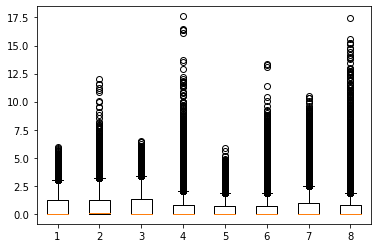

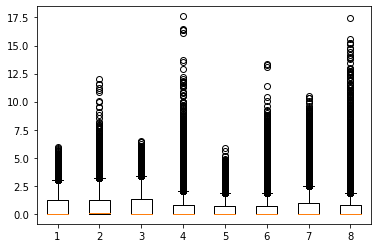

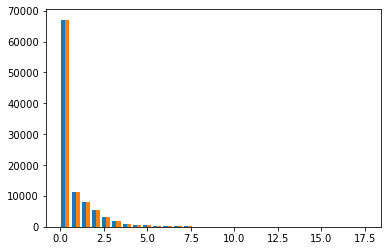

tensor(0., device='cuda:0')


In [9]:
a=F.relu(net.conv1(inp))
layer_quantizer=wrapped_modules['conv2'].quantizer[0]
a_sim=layer_quantizer.quant_activation(a)

plt.boxplot(a.transpose(1,-1).reshape(-1,a.size(1)).cpu().data.numpy())
plt.show()
plt.boxplot(a_sim.transpose(1,-1).reshape(-1,a.size(1)).cpu().data.numpy())
plt.show()

plt.hist([a_sim.view(-1).cpu().data.numpy(),a.view(-1).cpu().data.numpy()],bins=30)
# plt.plot([layer_quantizer.get_optimal_clipping_value()]*2,[0,10000])
plt.show()
print((a_sim-a).mean())

In [10]:
def plot_feature_map(feature_map,max_plot=18):
    c=feature_map.shape[0]
    if c>max_plot:
        c=max_plot
    for i in range(c):
        plt.subplot(1,c,i+1)
        plt.imshow(feature_map[i])

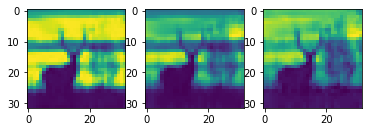

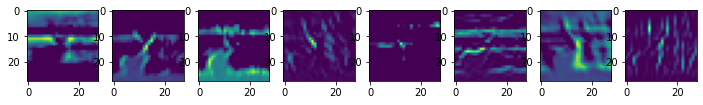

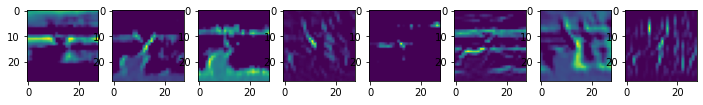

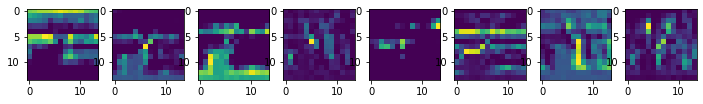

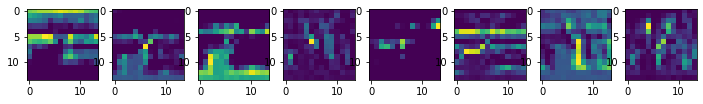

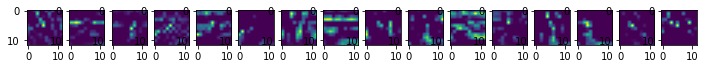

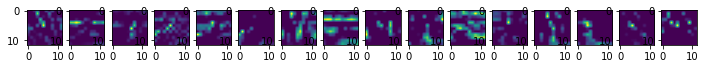

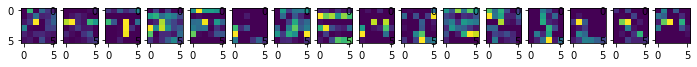

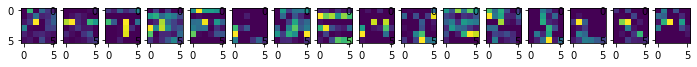

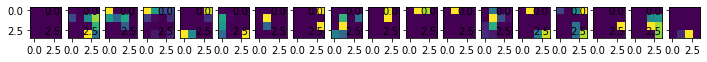

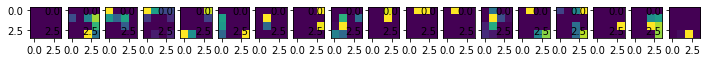

In [11]:
for name,module in wrapped_modules.items():
    module.mode='quant_forward'
pos=0
tot=0
with torch.no_grad():
    for inp,target in test_loader:
        inp=inp.cuda()
        target=target.cuda()
        out=net.forward_feature(inp)
        raw_out=raw_net.forward_feature(inp)
        T=out[-1].argmax(1)!=raw_out[-1].argmax(1)
        if T.any():
            
            idx=T.long().argmax()
            im=inp[idx].cpu().data.numpy()
            plot_feature_map(im)
            plt.show()
            show_features=[0,1,2,3,4]
            for show_feature in show_features:
                plot_feature_map(out[show_feature][idx].cpu().data.numpy())
                plt.gcf().set_size_inches(12,60)
                plt.show()
                plot_feature_map(raw_out[show_feature][idx].cpu().data.numpy())
                plt.gcf().set_size_inches(12,60)
                plt.show()
            # print(out[-2][idx])
            # print(raw_out[-2][idx])
            break

In [12]:
out[-2][idx,3]

tensor([[4.7892, 2.7167, 1.0822, 1.0813],
        [0.8343, 0.1261, 0.0000, 0.6211],
        [0.0499, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3266, 0.0000, 0.4428]], device='cuda:0')

In [13]:
raw_out[-2][idx,3]

tensor([[4.7070, 2.6575, 1.0424, 1.0275],
        [0.7744, 0.0341, 0.0000, 0.5941],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3789, 0.0000, 0.4289]], device='cuda:0')

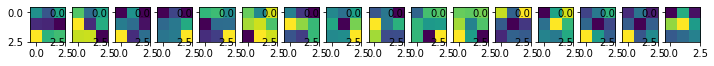

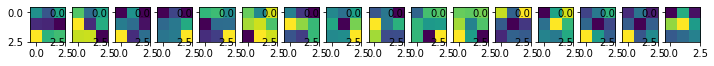

In [14]:
plot_feature_map(net.conv3.weight[3].cpu().data.numpy())
plt.gcf().set_size_inches(12,60)
plt.show()
plot_feature_map(raw_net.conv3.weight[3].cpu().data.numpy())
plt.gcf().set_size_inches(12,60)
plt.show()


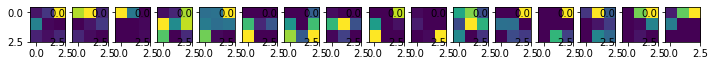

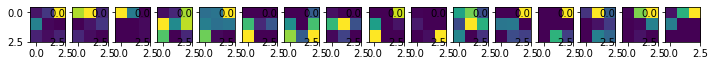

In [15]:
plot_feature_map(out[3][idx,:,2:5,0:3].cpu().data.numpy())
plt.gcf().set_size_inches(12,60)
plt.show()
plot_feature_map(raw_out[3][idx,:,2:5,0:3].cpu().data.numpy())
plt.gcf().set_size_inches(12,60)
plt.show()

In [17]:
# a=torch.sum(raw_out[3][idx,:,2:5,0:3]*raw_net.conv3.weight[3],[1,2])
a=torch.sum(raw_out[3][idx,:,2:5,0:3]*raw_net.conv3.weight[3],[1,2])
b=torch.sum(out[3][idx,:,2:5,0:3]*wrapped_modules['conv3'].quantizer[0].quant_weight(wrapped_modules['conv3'].weight[3]),[1,2])
# b=torch.sum(raw_out[3][idx,:,2:5,0:3]*raw_net.conv3.weight[3],[1,2])
print(a)
print(b)
print(a-b)
print(sum(a),sum(b))

tensor([ 0.5258,  0.8118, -0.5410, -0.2203, -0.2654, -0.1747,  0.3671,  0.1231,
        -0.6306,  0.0418,  0.5190, -0.0235,  0.0478, -0.4213, -0.1471, -0.0431],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([ 0.5476,  0.8178, -0.5249, -0.2052, -0.2679, -0.1744,  0.3624,  0.1129,
        -0.6268,  0.0420,  0.5323,  0.0045,  0.0466, -0.4237, -0.1462, -0.0407],
       device='cuda:0')
tensor([-0.0218, -0.0060, -0.0161, -0.0151,  0.0025, -0.0003,  0.0046,  0.0103,
        -0.0038, -0.0002, -0.0132, -0.0281,  0.0012,  0.0024, -0.0009, -0.0024],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor(-0.0306, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0562, device='cuda:0')


In [18]:
raw_out[3][idx,:,2:5,0:3][8]

tensor([[0.0000, 0.0000, 2.1060],
        [1.2793, 0.0000, 0.1198],
        [2.2807, 0.0000, 0.0000]], device='cuda:0')

In [19]:
out[3][idx,:,2:5,0:3][8]

tensor([[0.0000, 0.0000, 2.0814],
        [1.2689, 0.0000, 0.1060],
        [2.2927, 0.0000, 0.0000]], device='cuda:0')

In [20]:
raw_net.conv3.weight[3][8]

tensor([[-0.2103, -0.1672, -0.2986],
        [ 0.0320, -0.1672, -0.0874],
        [-0.0142, -0.2232, -0.2210]], device='cuda:0',
       grad_fn=<SelectBackward>)